In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from benchmark_pipeline import read_features, run_cumusort, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data, accuracy_plot, calc_metrics
from benchmark_pipeline import calc_picp, calc_qcp
### input
folder = 'http://192.168.1.30:8333/ai4sh-landmasked/model_benchmark'

prop_list = ['ocd','oc','bulk_density', 'ph_cacl2','ph_h2o','N','caco3','K','EC','P','CEC','texture1','texture2'] # unitl N everything has lightGBM models
space_list = ['log1p','log1p','normal', 'normal','normal','log1p','log1p','log1p','log1p','log1p','log1p','log1p','log1p'] # 
filt_list = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5] #5,5,5,5,

In [2]:
# set up
cv = GroupKFold(n_splits=5) 
rsl = []
prop = 'ocd'
space = 'log1p'
output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}'
tgt = f'{prop}_log1p'

# model
pathm = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/model_rf.{prop}_ccc.joblib'
model = joblib.load(pathm)
# model.n_jobs=90

# covariates
pathc = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt'
covs = read_features(pathc) 

# data
train = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_train.csv',low_memory=False)
train = train.dropna(subset=covs+[tgt],how='any')
test = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_test.csv',low_memory=False)
test = test.dropna(subset=covs+[tgt],how='any')

# model
model.n_jobs = 90
model.fit(train[covs], train[tgt])

RandomForestRegressor(max_depth=30, max_features=0.7, min_samples_leaf=2,
                      n_estimators=64, n_jobs=90)

#### trees, picp, piw, qcp

In [3]:
from trees_rf import cast_tree_rf
model = cast_tree_rf(model)
tree_predictions = model.predict(test[covs])

y_pred = np.mean(tree_predictions, axis=0)
y_pred = np.expm1(y_pred)

tree_predictions = np.expm1(tree_predictions)

quantiles = [0.005, 0.025, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.975, 0.995]
y_q = np.percentile(tree_predictions, [q * 100 for q in quantiles], axis=0)

In [4]:
from trees_rf import cast_tree_rf
model = cast_tree_rf(model)
tree_predictions = model.predict(test[covs])
tree_predictions = np.expm1(tree_predictions)

quantiles_95 = [0.025, 0.975]
y_95 = np.percentile(tree_predictions, [q * 100 for q in quantiles_95], axis=0)
piw = y_95[1,:] - y_95[0,:]

In [5]:
qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_q[ii,:], test[prop], quantiles[ii]))

pi = []
picp = []
piw_m = []
piw_med = []
for ii in range(12):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_q[ii,:], y_q[jj,:], test[prop]))
    piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
    piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))

### plot

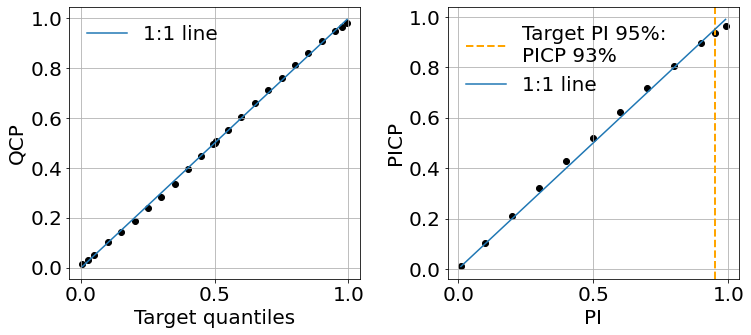

In [118]:
import matplotlib.pyplot as plt

# Create a 1x2 grid for the plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot 1: Target quantiles vs. realized quantiles
axs[0].plot(quantiles, quantiles, label='1:1 line')
axs[0].scatter(quantiles, qcp, color='black')
axs[0].set_xlabel('Target quantiles', fontsize=20)
axs[0].set_ylabel('QCP', fontsize=20)
axs[0].grid(True)
axs[0].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[0].tick_params(axis='both', which='major', labelsize=20)

# Plot 2: PI vs. PICP
# ymin, ymax = axs[1].get_ylim()
# axs[1].plot([0.95, 0.95], [0,1], 
#             color='orange', linestyle='--', linewidth=2, label='Target PI 95%:\nPICP 93%')
axs[1].axvline(x=0.95, color='orange', linestyle='--', linewidth=2, label='Target PI 95%:\nPICP 93%')  # Use axvline to draw a vertical line across the entire plot
axs[1].plot(pi, pi, label='1:1 line')
axs[1].scatter(pi, picp, color='black')
axs[1].set_xlabel('PI', fontsize=20)
axs[1].set_ylabel('PICP', fontsize=20)
# axs[1].text(0.26, 0.16, f'PI 95% - PICP 93%', #\n{picp[1]:.2f}
#             ha='left', va='top', transform=axs[1].transAxes, fontsize=20)  # Adjusted text position
axs[1].grid(True)
axs[1].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[1].tick_params(axis='both', which='major', labelsize=20)

# Adjust layout to prevent overlapping and add space between the panels
plt.subplots_adjust(wspace=0.3)  # Increase the space between the two plots
plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_uncertainty.evaluation.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Show the combined figure
plt.show()



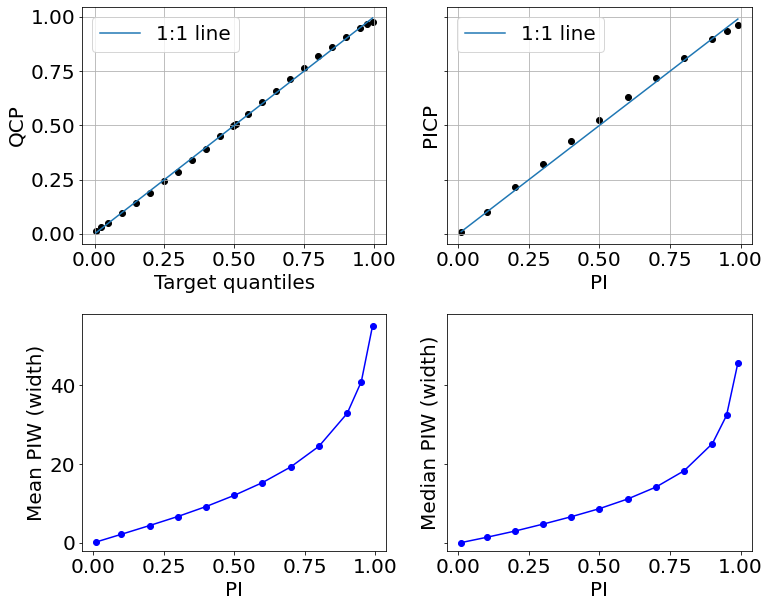

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey='row')

# Plot 1: Target quantiles vs. realized quantiles
axs[0, 0].plot(quantiles, quantiles, label='1:1 line')
axs[0, 0].scatter(quantiles, qcp, color='black')
axs[0, 0].set_xlabel('Target quantiles', fontsize=20)
axs[0, 0].set_ylabel('QCP', fontsize=20)
axs[0, 0].grid(True)
axs[0, 0].legend(fontsize=20)
axs[0, 0].tick_params(axis='both', which='major', labelsize=20)

# Plot 2: PI vs. PICP
axs[0, 1].plot(pi, pi, label='1:1 line')
axs[0, 1].scatter(pi, picp, color='black')
axs[0, 1].set_xlabel('PI', fontsize=20)
axs[0, 1].set_ylabel('PICP', fontsize=20)
axs[0, 1].grid(True)
axs[0, 1].legend(fontsize=20)
axs[0, 1].tick_params(axis='both', which='major', labelsize=20)

# Plot 3: Mean PIW (width) - Line Plot
axs[1, 0].plot(pi, piw_m, color='blue', marker='o')
# axs[1, 0].set_xticks(pi[::2])  # Show every second x-tick to avoid overlap
# axs[1, 0].set_xticklabels([f'{p}' for p in pi[::2]], fontsize=20)
axs[1, 0].set_xlabel('PI', fontsize=20)
axs[1, 0].set_ylabel('Mean PIW (width)', fontsize=20)
axs[1, 0].tick_params(axis='both', which='major', labelsize=20)
axs[1, 0].set_ylim([-2, 58])
# axs[1, 0].legend(fontsize=20)

# Plot 4: Median PIW (width) - Line Plot
axs[1, 1].plot(pi, piw_med, color='blue', marker='o')
# axs[1, 1].set_xticks(pi[::2])  # Show every second x-tick to avoid overlap
# axs[1, 1].set_xticklabels([f'{p}' for p in pi[::2]], fontsize=20)
axs[1, 1].set_xlabel('PI', fontsize=20)
axs[1, 1].set_ylabel('Median PIW (width)', fontsize=20)
axs[1, 1].tick_params(axis='both', which='major', labelsize=20)
axs[1, 1].set_ylim([-2, 58])
# axs[1, 1].legend(fontsize=20)

# Adjust layout to prevent overlapping and add space between the panels
plt.subplots_adjust(hspace=0.3)  # Increase the space between the top and bottom panels

# Show the combined figure
plt.show()


### PDP of PIW

In [78]:
def custom_predict_piw(model, X):
    tree_predictions = model.predict(X)
    tree_predictions = np.expm1(tree_predictions)
    quantiles = [0.025, 0.975]
    y_q = np.percentile(tree_predictions, [q * 100 for q in quantiles], axis=0)
    piw = y_q[1,:] - y_q[0,:]
    return piw

def compute_pdp(model, X, feature_index, predict_function, grid_resolution=100):
    """
    Compute partial dependence for a specific feature.

    Parameters:
    - model: The fitted model.
    - X: The dataset (numpy array or pandas DataFrame).
    - feature_index: The index of the feature for which to compute PDP.
    - predict_function: Function to compute the target values.
    - grid_resolution: Number of points in the grid.

    Returns:
    - values: The feature values at which PDP was computed.
    - pdp: The corresponding partial dependence values.
    """
    X = X.copy()
    feature_values = np.linspace(X.iloc[:, feature_index].min(), 
                                 X.iloc[:, feature_index].max(), 
                                 grid_resolution)
    
    pdp = np.zeros(grid_resolution)
    
    for i, val in enumerate(feature_values):
        X.iloc[:, feature_index] = val
        pdp[i] = predict_function(model, X).mean()

    return feature_values, pdp



In [189]:
with open('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/piw_pdp.results.pkl', 'rb') as file:
    piw_pdp = pickle.load(file)
    
piw_df = pd.DataFrame(columns = ['Feature', 'name', 'pdp_range', 'pdp_mean'])
    
    
# sig = ['hzn_dep',
#  'lithology.78.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif',
#  'dtm.bareearth_ensemble_p10_30m_s_20000101_20221231_eu_epsg.3035_v20240424',
#  'dtm.bareearth_ensemble_p10_960m_s_20000101_20221231_eu_epsg.3035_v20240424.tif',
#  'dtm.bareearth_ensemble_p10_480m_s_20000101_20221231_eu_epsg.3035_v20240424.tif',
#  'ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127',
#  'vpd.range_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531.tif',
#  'red_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
#  'wilderness_li2022.human.footprint_p_1km_s_{year}0101_{year}1231_eu_epsg.3035_v20240531.tif',
#  'wv_mcd19a2v061.seasconv_m_1km_s_{year}0501_{year}0531_eu_epsg.3035_v20230619.tif']

for i, xx in enumerate(sig):
    if len(xx.split('_'))>2:
        nx = xx.split('_')[0]+'_'+xx.split('_')[2]+'_'+xx.split('_')[5]+'_'+xx.split('_')[6]
    else:
        nx = xx
        
    # feature_values, pdp = compute_pdp(model, test[covs], i, custom_predict_piw, grid_resolution=100)
    pdp_piw_results[xx] = {
        "feature_values": feature_values,
        "pdp_values": pdp
    }
    feature_values = piw_pdp[xx]['feature_values']
    pdp = piw_pdp[xx]['pdp_values']
    
    pdp_range = np.max(pdp) - np.min(pdp)
    pdp_mean = np.mean(pdp)
    piw_df.loc[len(piw_df)] = [xx, nx, pdp_range, pdp_mean] 
    
# with open('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/piw_pdp.results.pkl', 'wb') as file:
#     pickle.dump(pdp_piw_results, file)   

In [190]:
piw_df = piw_df.sort_values(by=['pdp_range'], ascending=False)#['Feature'].tolist()


,Feature,name,pdp_range,pdp_mean
0,hzn_dep,hzn_dep,27.341046,36.530587
1,lithology.78.lithology_egdi.1m_c_250m_s_200001...,lithology.78.lithology_c_20000101_20221231,24.846279,56.555275
2,dtm.bareearth_ensemble_p10_30m_s_20000101_2022...,dtm.bareearth_p10_20000101_20221231,16.334087,43.977840
3,dtm.bareearth_ensemble_p10_960m_s_20000101_202...,dtm.bareearth_p10_20000101_20221231,16.032095,42.898948
4,dtm.bareearth_ensemble_p10_480m_s_20000101_202...,dtm.bareearth_p10_20000101_20221231,14.544174,42.736439
5,ndvi_glad.landsat.ard2.seasconv.longterm_p25_3...,ndvi_p25_20000101_20221231,13.899543,44.757948
6,vpd.range_chelsa_m_1km_s_19810101_20101231_eu_...,vpd.range_m_19810101_20101231,11.023384,46.313096
7,red_glad.landsat.ard2.seasconv.m.yearly_p75_30...,red_p75_{year}0101_{year}1231,11.010063,42.189820
8,wilderness_li2022.human.footprint_p_1km_s_{yea...,wilderness_p_{year}0101_{year}1231,10.296193,43.241488
9,wv_mcd19a2v061.seasconv_m_1km_s_{year}0501_{ye...,wv_m_{year}0501_{year}0531,10.263016,44.661492


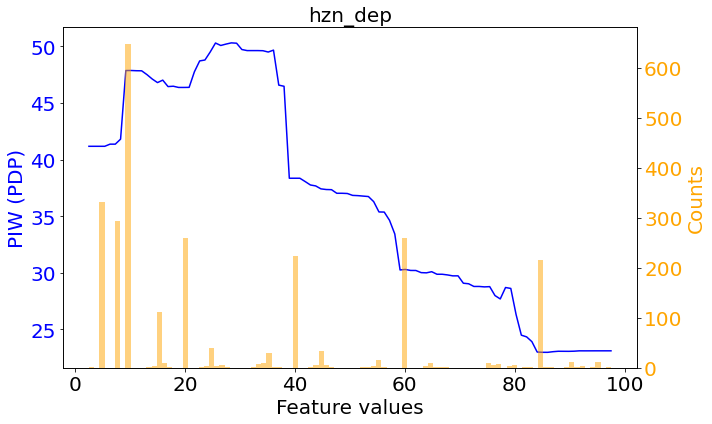

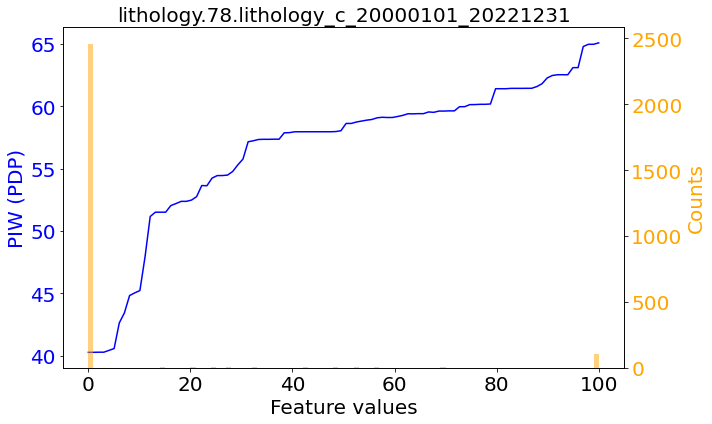

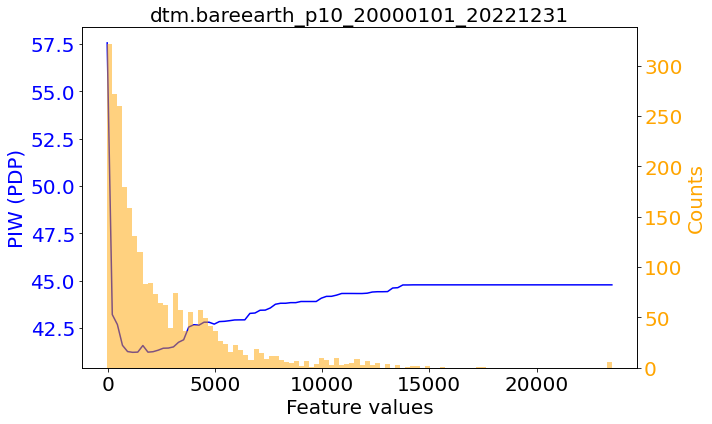

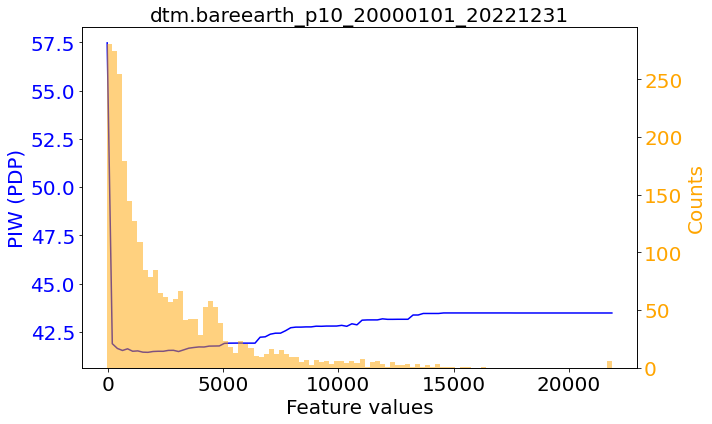

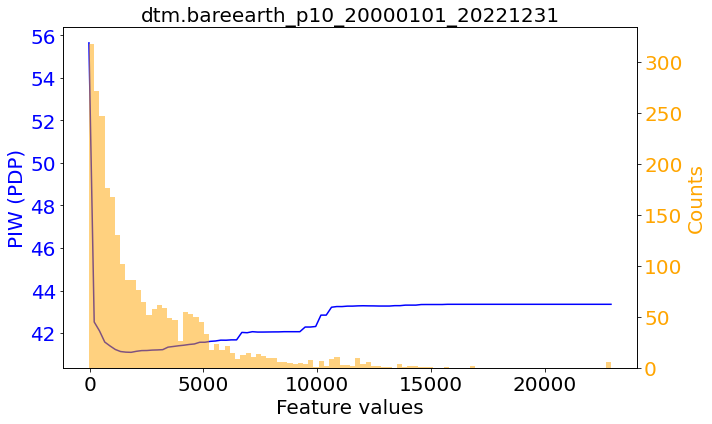

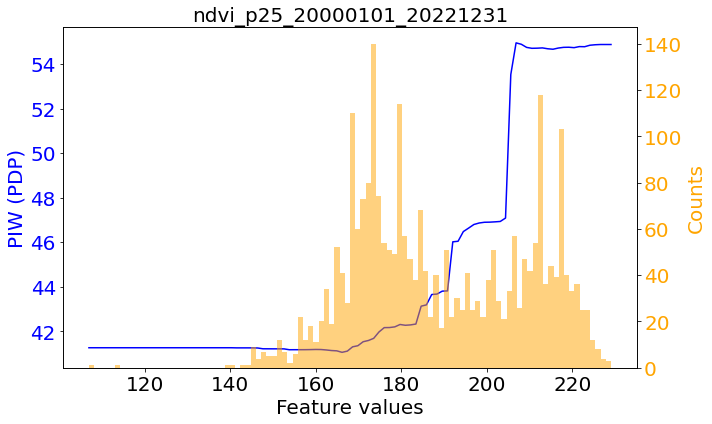

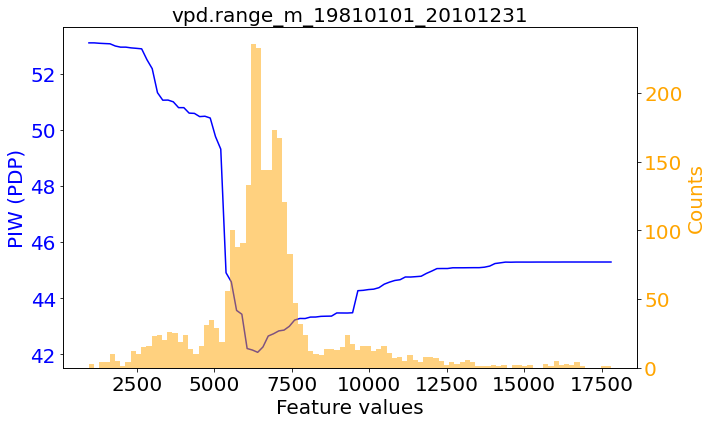

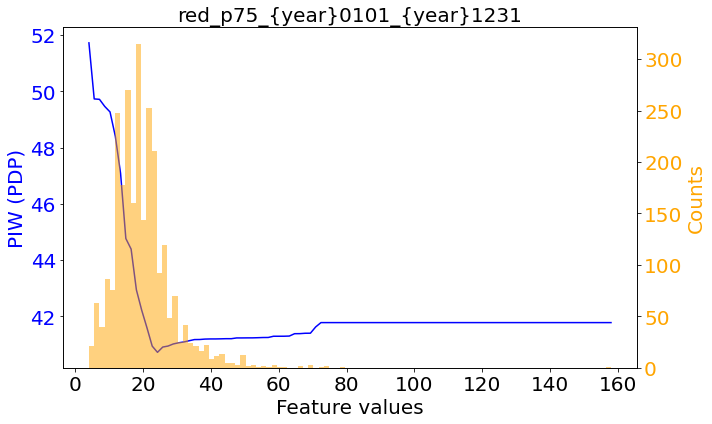

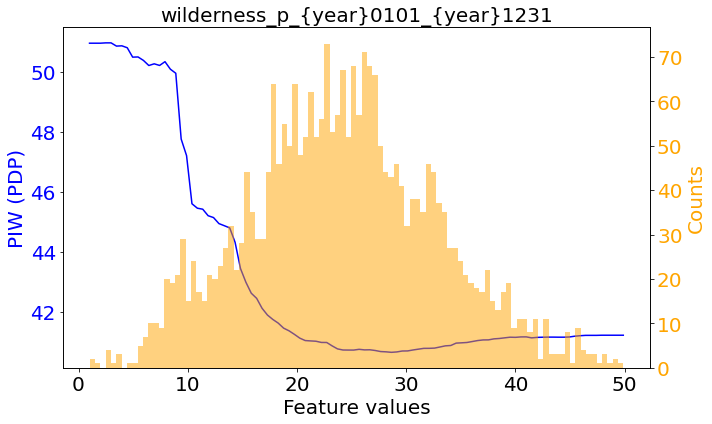

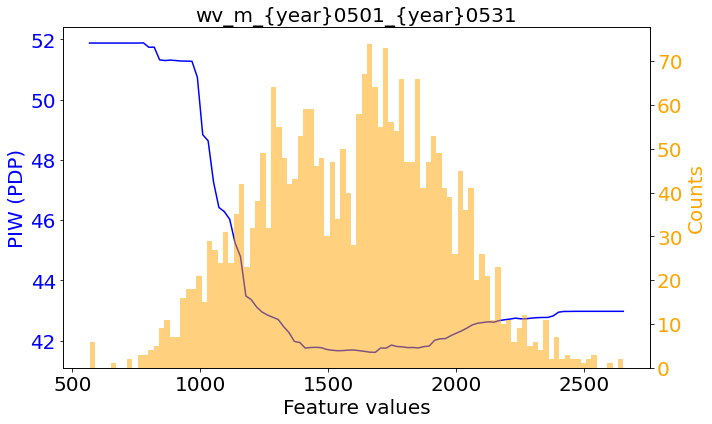

In [202]:
for xx in piw_df['Feature'].iloc[0:10]:
    if len(xx.split('_'))>2:
        nx = xx.split('_')[0]+'_'+xx.split('_')[2]+'_'+xx.split('_')[5]+'_'+xx.split('_')[6]
    else:
        nx = xx
        
    pdp_piw_results[xx] = {
        "feature_values": feature_values,
        "pdp_values": pdp
    }
    feature_values = piw_pdp[xx]['feature_values']
    pdp = piw_pdp[xx]['pdp_values']
        
    # PDP and histogram
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot the PDP
    ax1.plot(feature_values, pdp, color='blue', label='PDP')
    ax1.set_title(nx, fontsize=20)
    ax1.set_xlabel(f"Feature values", fontsize=20)
    ax1.set_ylabel("PIW (PDP)", fontsize=20, color='blue')
    ax1.tick_params(axis='both', labelsize=20)
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    
    # Plot the histogram
    ax2.hist(test[xx], bins=100, color='orange', alpha=0.5) #, edgecolor='black'
    ax2.set_ylabel("Counts", fontsize=20, color='orange')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Show the plot
    fig.tight_layout()
    plt.show()
    
#     fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
#     # Plot the PDP on the left
#     ax[0].plot(feature_values, pdp)
#     ax[0].set_title(f"PDP - {nx}", fontsize=20)
#     ax[0].set_ylabel("PIW", fontsize=20)
#     ax[0].set_xlabel(f"Feature: {nx}", fontsize=20)
#     ax[0].tick_params(axis='both', labelsize=20)
    
#     # Plot the histogram of the feature values on the right
#     ax[1].hist(test[xx], bins=20, color='orange') #, edgecolor='black'
#     ax[1].set_title(f"Histogram - {nx}", fontsize=20)
#     ax[1].set_ylabel("Frequency", fontsize=20)
#     ax[1].set_xlabel(f"Feature values", fontsize=20)
#     ax[1].tick_params(axis='both', labelsize=20)
    
#     plt.tight_layout()
#     plt.show()


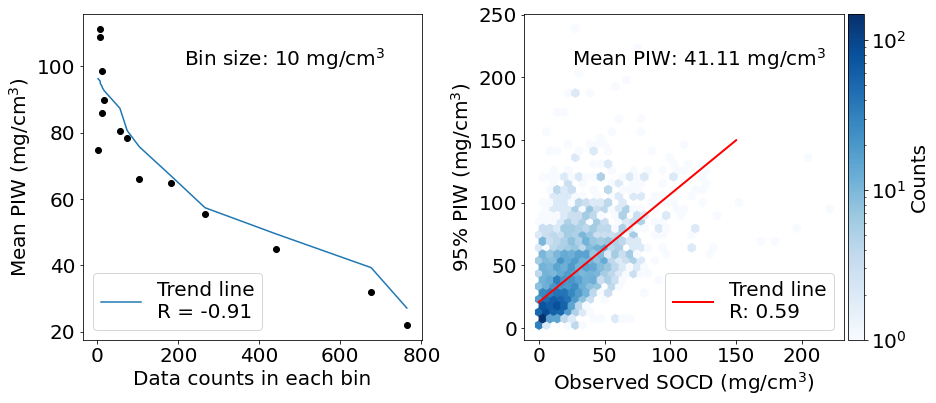

In [134]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot 1: Polynomial Fit with Scatter Plot
# Assuming y_true and piw are numpy arrays
# Define the number of bins
bins = np.linspace(0, 150, 16)

# Digitize the y_true values to find which bin each value belongs to
digitized = np.digitize(y_true, bins)

# Initialize lists to store results
mean_piw = []
p90_piw = []
p10_piw = []
counts = []

# Calculate mean, P90, and P10 of PIW in each bin, and count data points
for i in range(1, len(bins)):
    bin_data = piw[digitized == i]
    if len(bin_data) > 0:  # Only process if the bin is not empty
        mean_piw.append(np.mean(bin_data))
        p90_piw.append(np.percentile(bin_data, 90))
        p10_piw.append(np.percentile(bin_data, 10))
        counts.append(np.sum(digitized == i))

# Convert lists to numpy arrays
mean_piw = np.array(mean_piw)
p90_piw = np.array(p90_piw)
p10_piw = np.array(p10_piw)
counts = np.array(counts)

# Sort the data by counts
sorted_indices = np.argsort(counts)
counts_sorted = counts[sorted_indices]
mean_piw_sorted = mean_piw[sorted_indices]
p90_piw_sorted = p90_piw[sorted_indices]
p10_piw_sorted = p10_piw[sorted_indices]

# Fit a polynomial to the mean PIW data
degree = 3  # You can change this degree for a different polynomial fit
poly_coeffs = np.polyfit(counts_sorted, mean_piw_sorted, degree)
poly_fit = np.polyval(poly_coeffs, counts_sorted)

# Smooth the polynomial fit for a better visual appearance
smoothed_fit = uniform_filter1d(poly_fit, size=2)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Scatter Plot with Polynomial Fit (now on the left)
axs[0].scatter(counts_sorted, mean_piw_sorted, color='black')
axs[0].plot(counts_sorted, smoothed_fit, label=f'Trend line\nR = {np.corrcoef(counts_sorted, mean_piw_sorted)[0, 1]:.2f}')

# Set labels and title with increased font size
axs[0].set_xlabel('Data counts in each bin', fontsize=20)
axs[0].set_ylabel('Mean PIW (mg/cm$^3$)', fontsize=20)
axs[0].text(0.3, 0.9, f'Bin size: 10 mg/cm$^3$', 
            ha='left', va='top', transform=axs[0].transAxes, fontsize=20)  # Adjusted text position
axs[0].legend(loc='lower left', fontsize=20)
# Increase tick label size
axs[0].tick_params(axis='both', which='major', labelsize=20)


#### fit line
mask = (y_true >= 0) & (y_true <= 150)
y_true_filtered = y_true[mask]
piw_filtered = piw[mask]

coefficients = np.polyfit(y_true_filtered, piw_filtered, 1)
trend_line = np.poly1d(coefficients)
x_vals = np.linspace(0, 150, 500)

R = np.corrcoef(y_true, piw)[0, 1]

# Second subplot: Hexbin Plot (now on the right)
divider = make_axes_locatable(axs[1])
ax_cb = divider.append_axes("right", size="5%", pad=0.05)
hb = axs[1].hexbin(y_true, piw, gridsize=40, cmap='Blues', mincnt=1, bins='log', vmin=1, vmax=150)
piw_m = np.mean(piw)

# Create the colorbar and set the font size for the label and ticks
cbar = plt.colorbar(hb, cax=ax_cb, label='Counts')
cbar.ax.tick_params(labelsize=20)  # Set font size for colorbar ticks
cbar.set_label('Counts', fontsize=20)  # Set font size for colorbar label

# Set the font size for the axis labels and title
axs[1].set_xlabel('Observed SOCD (mg/cm$^3$)', fontsize=20)
axs[1].set_ylabel('95% PIW (mg/cm$^3$)', fontsize=20)
axs[1].text(0.15, 0.9, f'Mean PIW: {piw_m:.2f} mg/cm$^3$', 
            ha='left', va='top', transform=axs[1].transAxes, fontsize=20)  # Adjusted text position

axs[1].plot(x_vals, trend_line(x_vals), color='red', linewidth=2, label=f'Trend line\nR: {R:.2f}')

axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].legend(loc='lower right', fontsize=20)

# Match the aspect ratio of the plots
axs[0].set_aspect(aspect='auto')
axs[1].set_aspect(aspect='auto')

# Adjust layout to prevent overlap and add more space between plots
plt.subplots_adjust(wspace=0.3)  # Increase space between plots
plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_uncertainty.evaluation_piw.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Display the plots
plt.show()



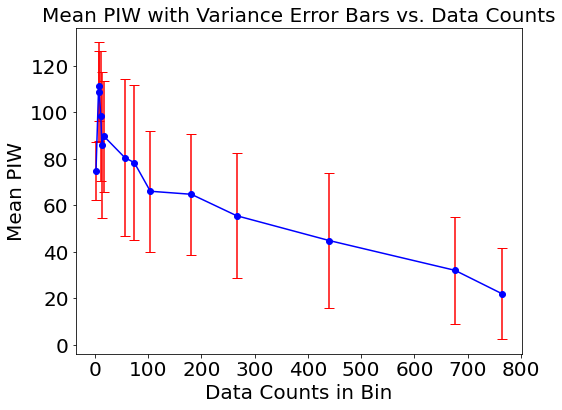

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true and piw are numpy arrays
# Define the number of bins
bins = np.linspace(0,150,16)

# Digitize the y_true values to find which bin each value belongs to
digitized = np.digitize(y_true, bins)

# Calculate mean and variance of PIW in each bin, and count data points
mean_piw = [np.mean(piw[digitized == i]) for i in range(1, len(bins))]
var_piw = [np.var(piw[digitized == i]) for i in range(1, len(bins))]
counts = [np.sum(digitized == i) for i in range(1, len(bins))]

# Calculate the standard deviation (sqrt of variance) for the error bars
std_piw = np.sqrt(var_piw)

# Sort the data by counts
sorted_indices = np.argsort(counts)
counts_sorted = np.array(counts)[sorted_indices]
mean_piw_sorted = np.array(mean_piw)[sorted_indices]
std_piw_sorted = np.array(std_piw)[sorted_indices]

# Create the plot with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(counts_sorted, mean_piw_sorted, yerr=std_piw_sorted, fmt='-o', color='blue', ecolor='red', capsize=5, label='Mean PIW')

# Set labels and title with increased font size
plt.xlabel('Data Counts in Bin', fontsize=20)
plt.ylabel('Mean PIW', fontsize=20)
plt.title('Mean PIW with Variance Error Bars vs. Data Counts', fontsize=20)

# Increase tick label size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show the plot
plt.show()






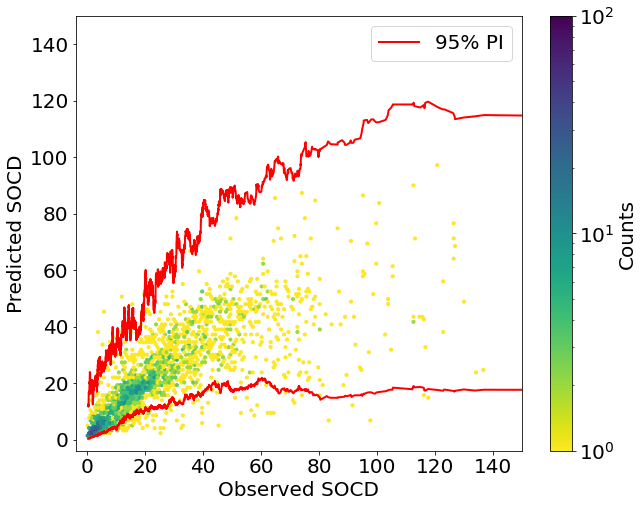

In [10]:

from scipy.ndimage import uniform_filter1d
import numpy as np
import matplotlib.pyplot as plt

# Sorting the true values
y_true = test[prop].values
sorted_indices = np.argsort(y_true)
pred_p975 = y_q[23,:]
pred_p025 = y_q[1,:]

# Reordering the arrays based on the sorted indices
sorted_true_values = y_true[sorted_indices]
sorted_pred_values = y_pred[sorted_indices]
sorted_pred_p025 = pred_p025[sorted_indices]
sorted_pred_p975 = pred_p975[sorted_indices]

# Applying a moving average to smooth the prediction intervals
window_size = 40#80  # Adjust the window size as needed
smoothed_pred_p025 = uniform_filter1d(sorted_pred_p025, size=window_size)
smoothed_pred_p975 = uniform_filter1d(sorted_pred_p975, size=window_size)

# Increase the figure size
plt.figure(figsize=(10, 8))
# plt.fill_between(sorted_true_values, smoothed_pred_p025, smoothed_pred_p975, color='gray', alpha=0.4, label='95% PI')
hb = plt.hexbin(sorted_true_values, sorted_pred_values, gridsize=150, cmap='viridis_r', bins='log', 
                extent=[-4, 150, -4, 150], mincnt=1, vmin=1, vmax=100)
cb = plt.colorbar(hb)
cb.set_label('Counts', fontsize=20)
cb.ax.tick_params(labelsize=20)

plt.plot(sorted_true_values, smoothed_pred_p025, color='red', linewidth=2)
plt.plot(sorted_true_values, smoothed_pred_p975, color='red', linewidth=2, label='95% PI')



# Adding labels and title with increased fontsize
plt.xlabel('Observed SOCD', fontsize=20)
plt.ylabel('Predicted SOCD', fontsize=20)

# Adding a legend with increased fontsize
plt.legend(fontsize=20)
plt.xlim([-4, 150])
plt.ylim([-4, 150])
# Increase tick label size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show the plot
plt.show()


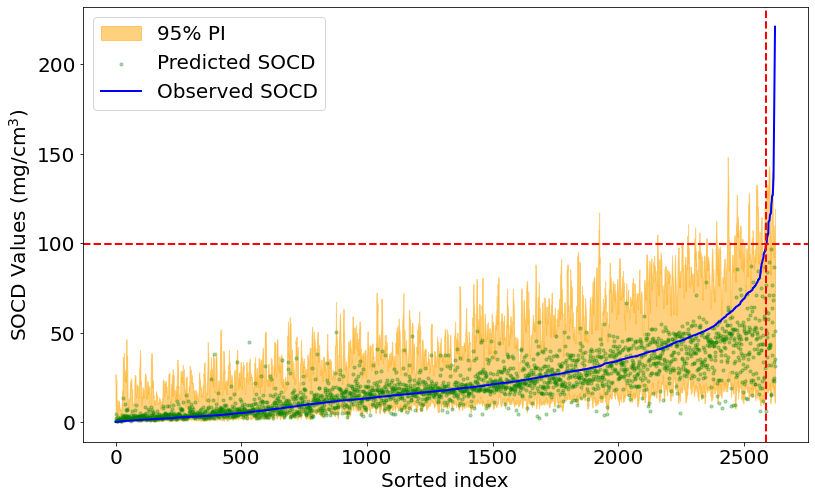

In [159]:
from scipy.ndimage import uniform_filter1d
import numpy as np
import matplotlib.pyplot as plt

# Sorting the true values
y_true = test[prop].values
sorted_indices = np.argsort(y_true)

# Reordering the arrays based on the sorted indices
sorted_true_values = y_true[sorted_indices]
sorted_pred_values = y_pred[sorted_indices]
sorted_pred_p025 = pred_p025[sorted_indices]
sorted_pred_p975 = pred_p975[sorted_indices]

# Applying a moving average to smooth the prediction intervals
window_size = 5  # Adjust the window size as needed
smoothed_pred_p025 = uniform_filter1d(sorted_pred_p025, size=window_size)
smoothed_pred_p975 = uniform_filter1d(sorted_pred_p975, size=window_size)

# Increase the figure size
plt.figure(figsize=(13, 8))

# Shading the smoothed prediction interval
plt.fill_between(range(len(sorted_pred_values)), smoothed_pred_p025, smoothed_pred_p975, color='orange', alpha=0.5, label='95% PI')

# Scatter plot for the predicted values with reduced dot size
plt.scatter(range(len(sorted_pred_values)), sorted_pred_values, label='Predicted SOCD', alpha=0.3, color='green', s=10)

# Plotting the true values
plt.plot(sorted_true_values, label='Observed SOCD', color='blue', linewidth=2)

closest_value_index = np.argmin(np.abs(sorted_true_values - 100))
closest_value = sorted_true_values[closest_value_index]

# Adding a horizontal and vertical line at the closest value to 100
plt.axhline(y=closest_value, color='red', linestyle='--', linewidth=2)
plt.axvline(x=closest_value_index, color='red', linestyle='--', linewidth=2)

# Adding labels and title with increased fontsize
plt.xlabel('Sorted index', fontsize=20)
plt.ylabel('SOCD Values (kg/m$^3$)', fontsize=20)
# plt.title('Sorted Plot with Smoothed Prediction Interval', fontsize=20)

# Adding a legend with increased fontsize
plt.legend(fontsize=20)

# Increase tick label size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_uncertainty.evaluation_sorted.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


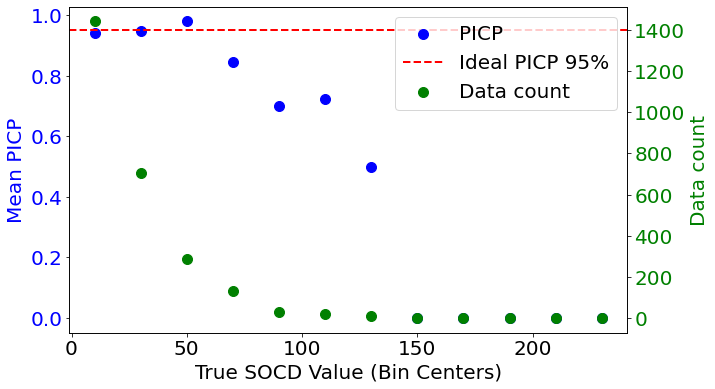

In [169]:
import numpy as np
import matplotlib.pyplot as plt

# Set the bin size (adjust this value as needed)
bin_size = 20

# Define bin edges with the adjustable bin size
bin_edges = np.arange(start=np.floor(sorted_true_values.min() / bin_size) * bin_size, 
                      stop=np.ceil(sorted_true_values.max() / bin_size) * bin_size + bin_size, 
                      step=bin_size)

# Digitize the true values to assign them to bins
bins = np.digitize(sorted_true_values, bin_edges)

# Initialize lists to store bin centers, PICP values, and counts of data points
bin_centers = []
picp_values = []
data_points_count = []

# Calculate the PICP for each bin and count the data points
for i in range(1, len(bin_edges)):
    # Select indices where the true values fall into the current bin
    bin_indices = np.where(bins == i)[0]
    
    if len(bin_indices) > 0:
        # Calculate the PICP for the current bin
        in_interval = (sorted_pred_p025[bin_indices] <= sorted_true_values[bin_indices]) & (sorted_true_values[bin_indices] <= sorted_pred_p975[bin_indices])
        picp = np.mean(in_interval)
        
        # Store the bin center, corresponding PICP value, and data points count
        bin_center = (bin_edges[i] + bin_edges[i-1]) / 2
        bin_centers.append(bin_center)
        picp_values.append(picp)
        data_points_count.append(len(bin_indices))


bin_centers = np.array(bin_centers)
picp_values = np.array(picp_values)
data_points_count = np.array(data_points_count)


fig, ax1 = plt.subplots(figsize=(10, 6))


p1 = ax1.scatter(bin_centers, picp_values, color='blue', s=100, label='PICP')
ax1.set_xlabel('True SOCD Value (Bin Centers)', fontsize=20)
ax1.set_ylabel('Mean PICP', fontsize=20, color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.axhline(y=0.95, color='red', linestyle='--', linewidth=2)

p2 = ax1.plot([], [], color='red', linestyle='--', linewidth=2, label='Ideal PICP 95%')

# Plotting the number of data points on the secondary y-axis
ax2 = ax1.twinx()
p3 = ax2.scatter(bin_centers, data_points_count, color='green', s=100, label='Data count')
ax2.set_ylabel('Data count', fontsize=20, color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=20)

# Combine legends
lines_labels = [p1, p2[0], p3]
labels = [l.get_label() for l in lines_labels]
ax1.legend(lines_labels, labels, loc='upper right', fontsize=20)

# Optionally, add a title
# plt.title('PICP and Data Points Count for Each Bin of True SOCD Values', fontsize=20)

plt.show()



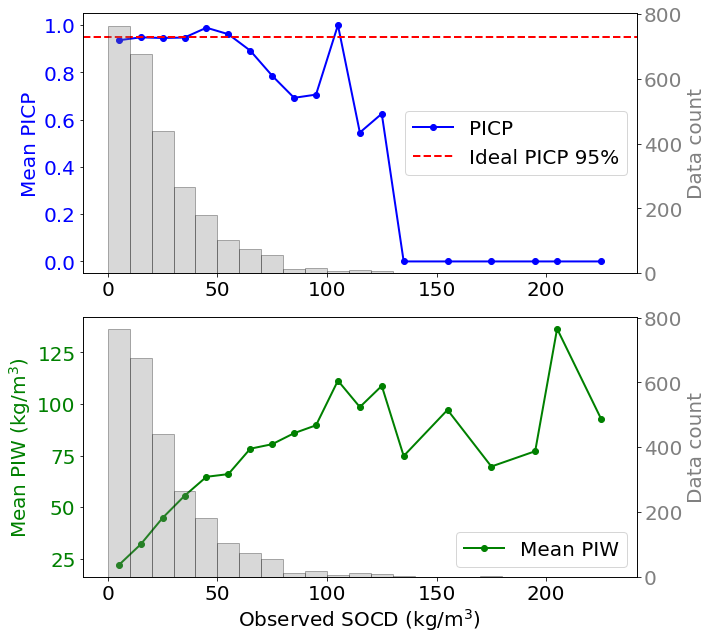

In [187]:
import numpy as np
import matplotlib.pyplot as plt

# Set the bin size (adjust this value as needed)
bin_size = 10

# Define bin edges with the adjustable bin size
bin_edges = np.arange(start=np.floor(sorted_true_values.min() / bin_size) * bin_size, 
                      stop=np.ceil(sorted_true_values.max() / bin_size) * bin_size + bin_size, 
                      step=bin_size)

# Digitize the true values to assign them to bins
bins = np.digitize(sorted_true_values, bin_edges)

# Initialize lists to store bin centers, PICP values, and PIW values
bin_centers = []
picp_values = []
piw_values = []

# Calculate the PICP and PIW for each bin
for i in range(1, len(bin_edges)):
    # Select indices where the true values fall into the current bin
    bin_indices = np.where(bins == i)[0]
    
    if len(bin_indices) > 0:
        # Calculate the PICP for the current bin
        in_interval = (sorted_pred_p025[bin_indices] <= sorted_true_values[bin_indices]) & (sorted_true_values[bin_indices] <= sorted_pred_p975[bin_indices])
        picp = np.mean(in_interval)
        
        # Calculate the PIW for the current bin
        piw = np.mean(sorted_pred_p975[bin_indices] - sorted_pred_p025[bin_indices])
        
        # Store the bin center, PICP value, and PIW value
        bin_center = (bin_edges[i] + bin_edges[i-1]) / 2
        bin_centers.append(bin_center)
        picp_values.append(picp)
        piw_values.append(piw)

# Convert lists to arrays for plotting
bin_centers = np.array(bin_centers)
picp_values = np.array(picp_values)
piw_values = np.array(piw_values)

# Create the figure with side-by-side subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9))

# Plotting the PICP and histogram in the first subplot
p1 = ax1.plot(bin_centers, picp_values, color='blue', linestyle='-', linewidth=2, marker='o', label='PICP') 
ax1.set_ylabel('Mean PICP', fontsize=20, color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.axhline(y=0.95, color='red', linestyle='--', linewidth=2)
# Adding a manual entry for the ideal PICP line
p2 = ax1.plot([], [], color='red', linestyle='--', linewidth=2, label='Ideal PICP 95%')

# Plotting the histogram on the secondary y-axis
ax3 = ax1.twinx()
ax3.hist(sorted_true_values, bins=bin_edges, color='gray', alpha=0.3, label='Histogram', edgecolor='black')
ax3.set_ylabel('Data count', fontsize=20, color='gray')
ax3.tick_params(axis='y', labelcolor='gray', labelsize=20)

# Combine legends for the first plot
lines_labels = [p1[0], p2[0]]  # Access the first element of p1
labels = [l.get_label() for l in lines_labels]
ax1.legend(lines_labels, labels, loc='center right', fontsize=20)

# Plotting the PIW and histogram in the second subplot
p4 = ax2.plot(bin_centers, piw_values, color='green', linestyle='-', linewidth=2, marker='o', label='Mean PIW')
ax2.set_xlabel('Observed SOCD (kg/m$^3$)', fontsize=20)
ax2.set_ylabel('Mean PIW (kg/m$^3$)', fontsize=20, color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)

# Plotting the histogram on the secondary y-axis
ax4 = ax2.twinx()
ax4.hist(sorted_true_values, bins=bin_edges, color='gray', alpha=0.3, label='Histogram', edgecolor='black')
ax4.set_ylabel('Data count', fontsize=20, color='gray')
ax4.tick_params(axis='y', labelcolor='gray', labelsize=20)

# Combine legends for the second plot
lines_labels = [p4[0]]  # Access the first element of p4
labels = [l.get_label() for l in lines_labels]
ax2.legend(lines_labels, labels, loc='lower right', fontsize=20)

# Optionally, add a title for the entire figure
# fig.suptitle('PICP and PIW with Corresponding Histogram of True SOCD Values', fontsize=24)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_uncertainty.evaluation_picp.piw.hist.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Display the plots
plt.show()



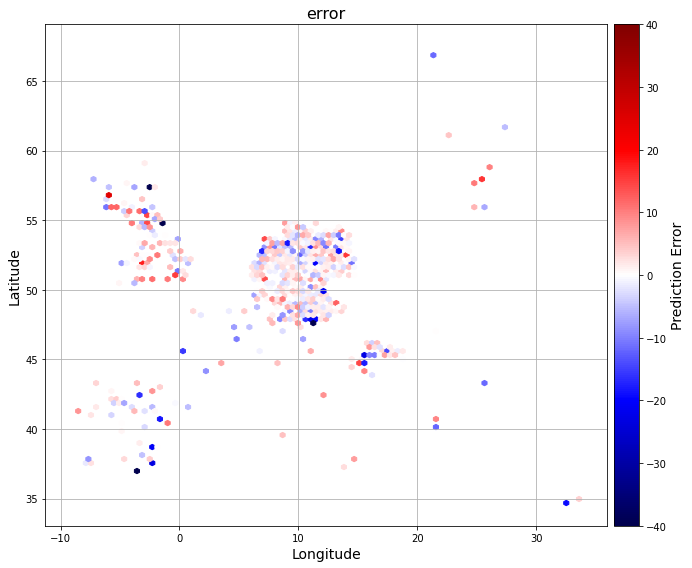

In [187]:
y_error = y_pred - test[prop]

fig, ax = plt.subplots(figsize=(11, 8))
hexbin = ax.hexbin(test['lon'], test['lat'], C=y_error, gridsize=100, cmap='seismic', mincnt=1,
                   reduce_C_function=np.mean, vmin=-40, vmax=40)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title(f'error', fontsize=16)


# Create colorbar with proper alignment
colorbar = fig.colorbar(hexbin, ax=ax, pad=0.01)
colorbar.set_label('Prediction Error', fontsize=14)

plt.grid(True)

# Use tight_layout with custom rect to avoid cutting off labels or the colorbar
plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust these values as necessary



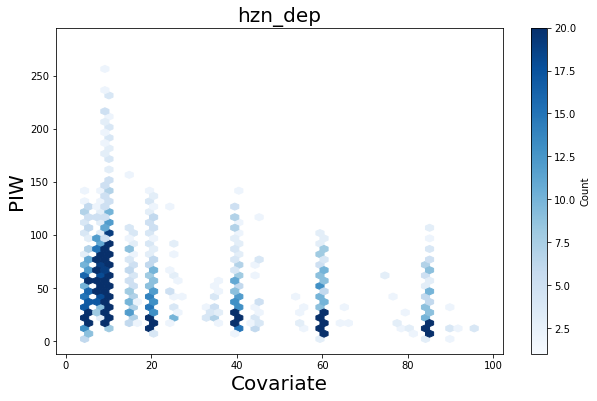

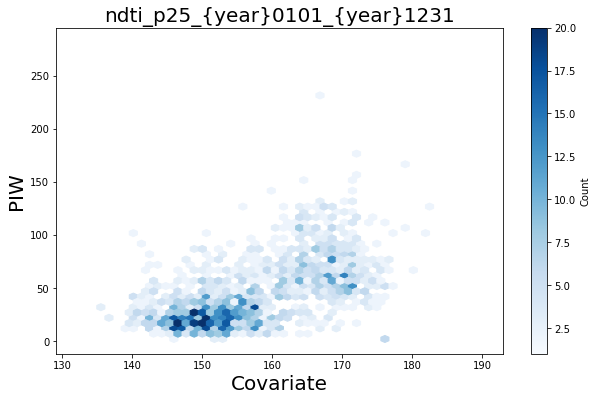

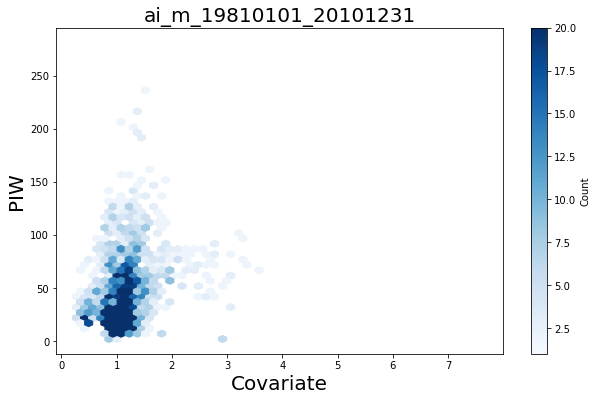

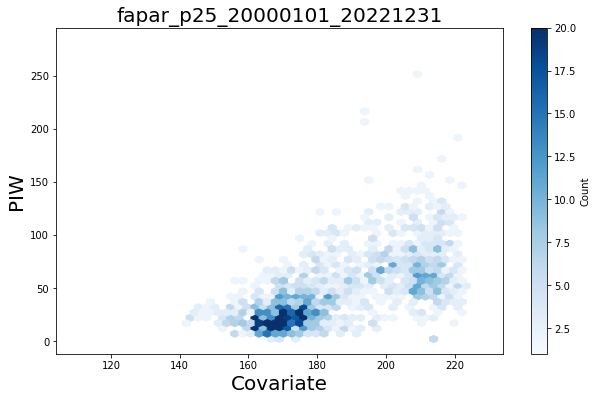

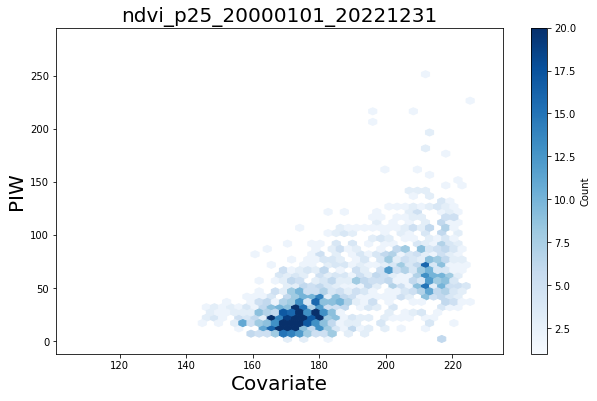

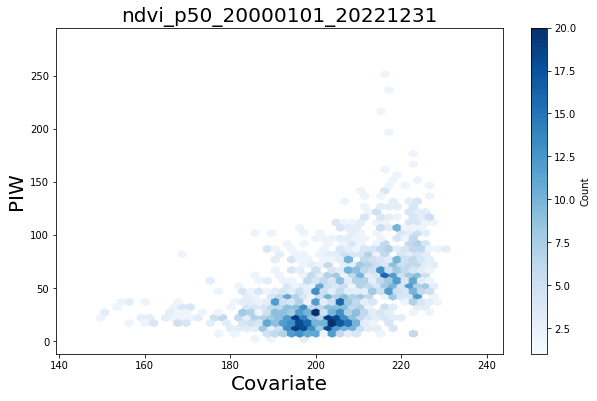

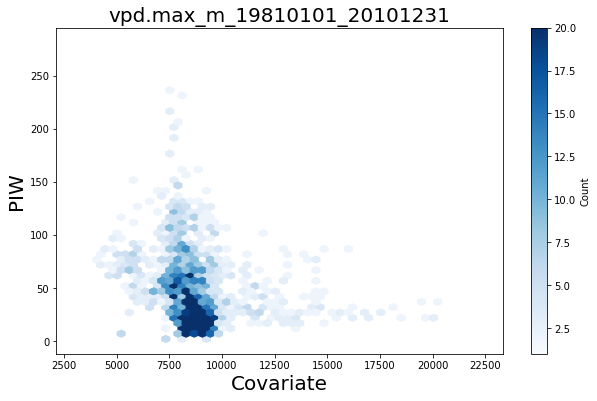

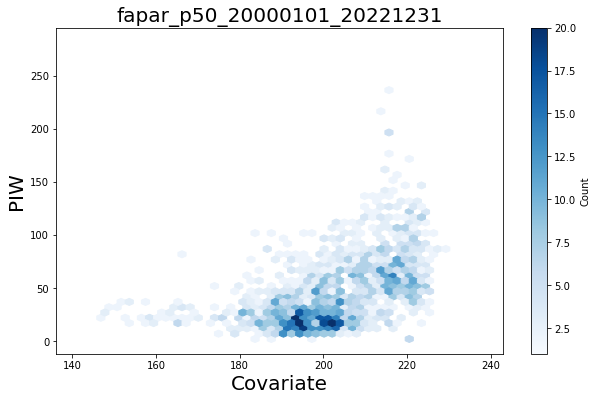

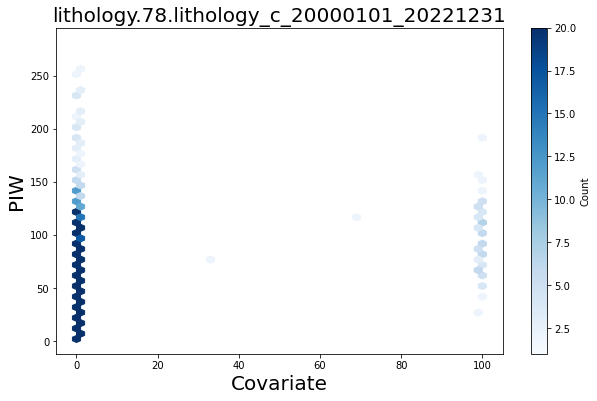

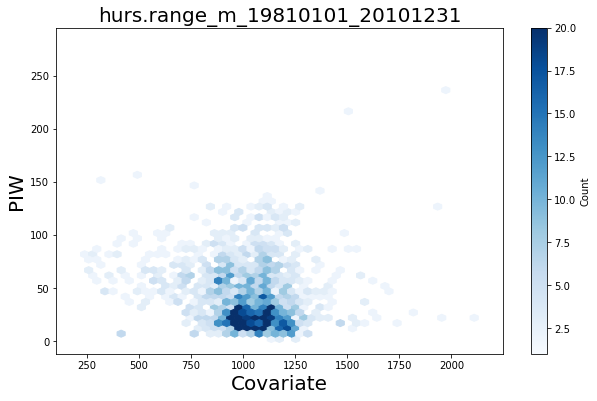

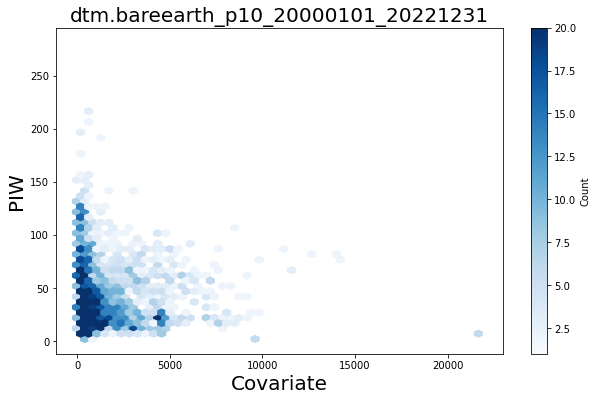

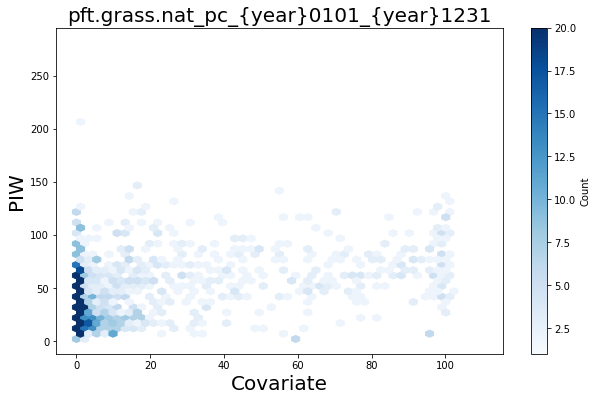

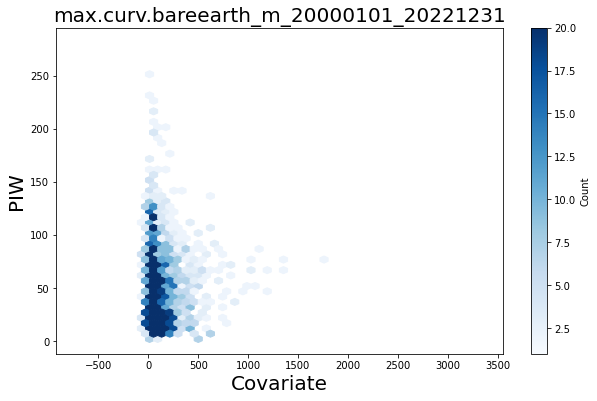

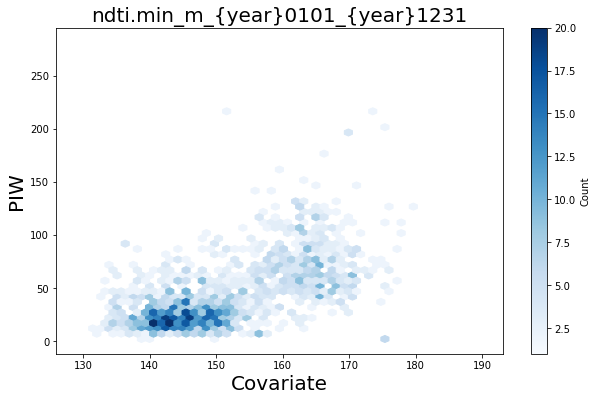

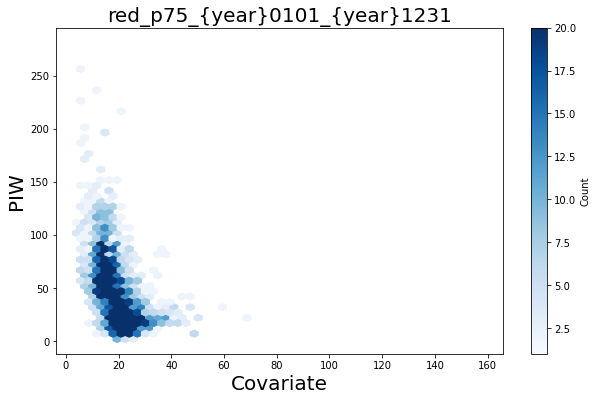

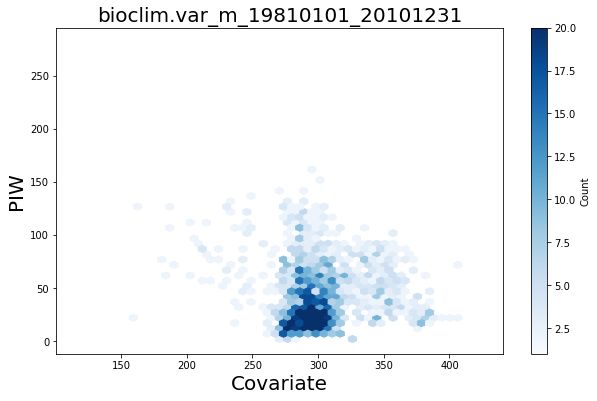

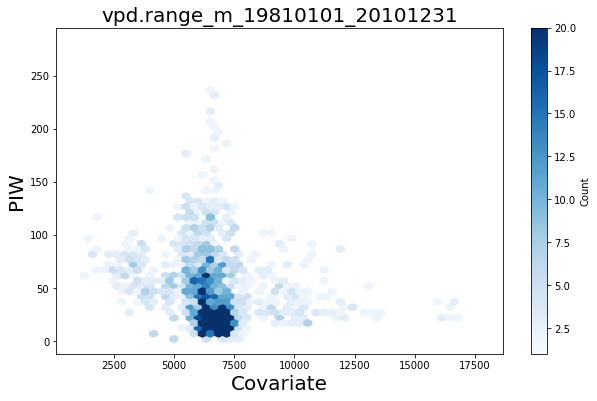

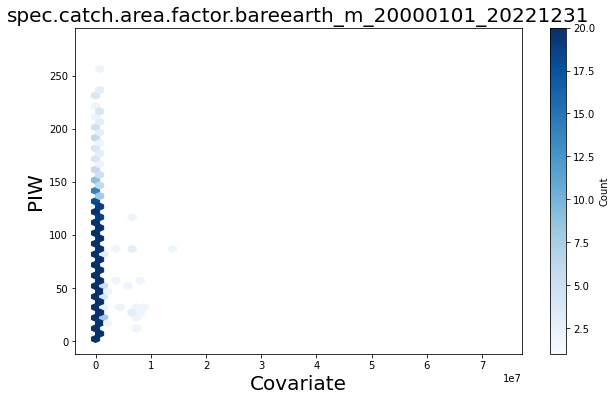

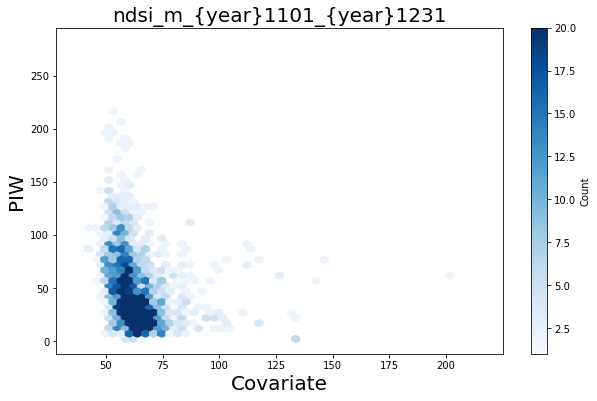

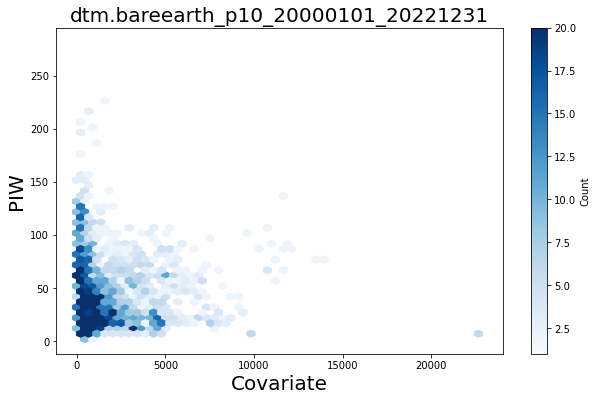

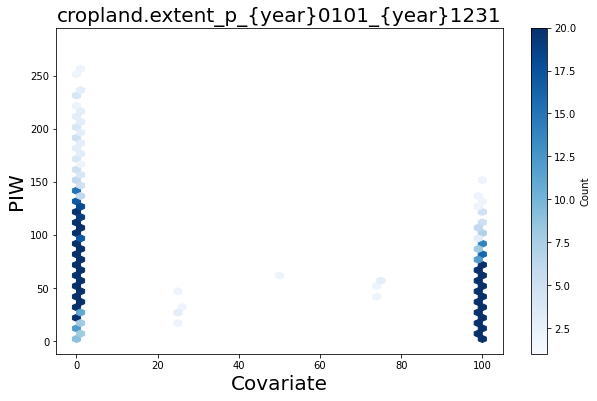

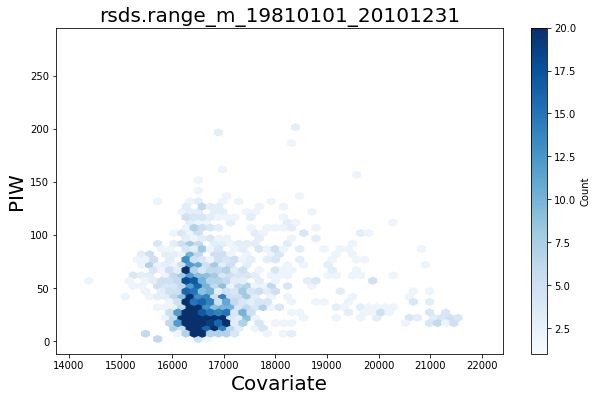

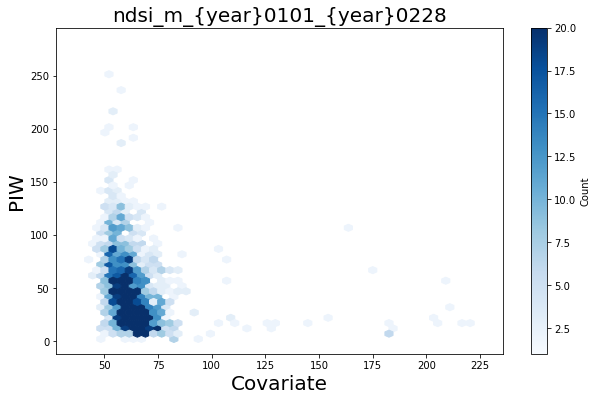

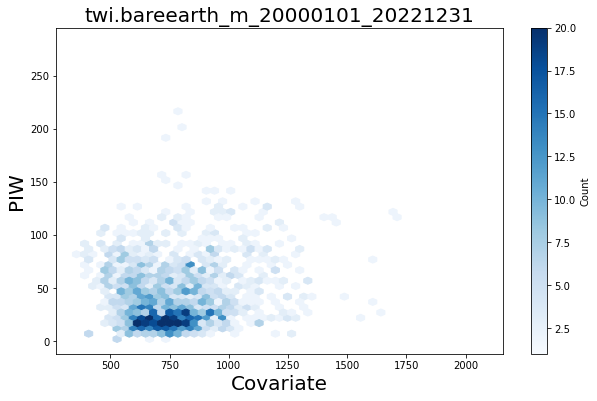

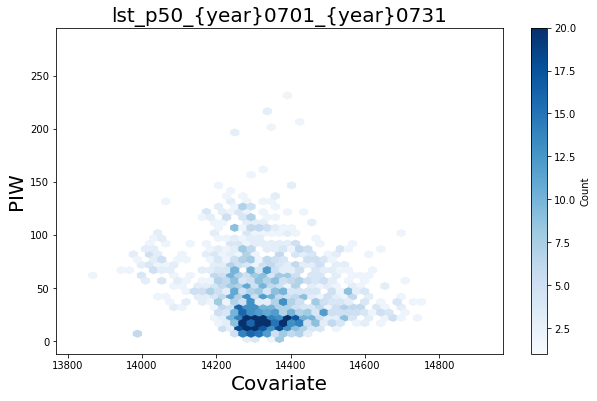

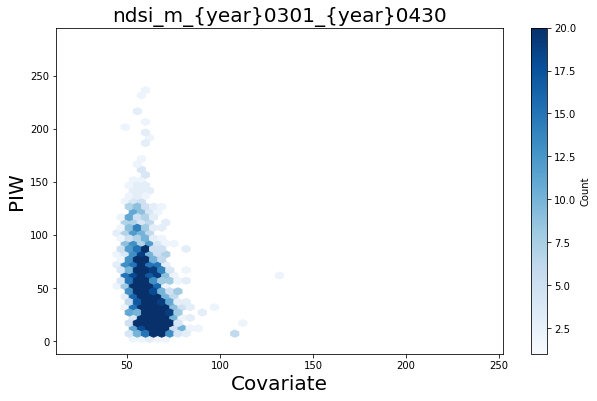

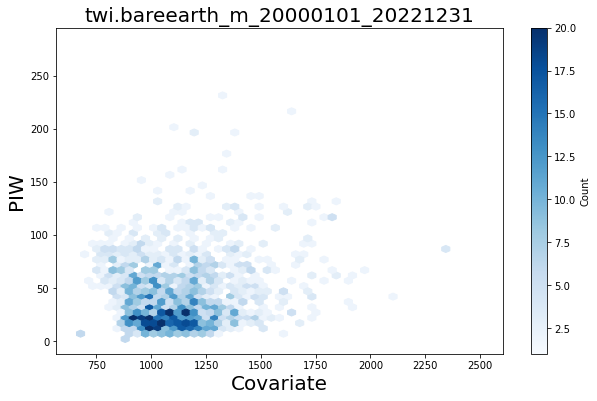

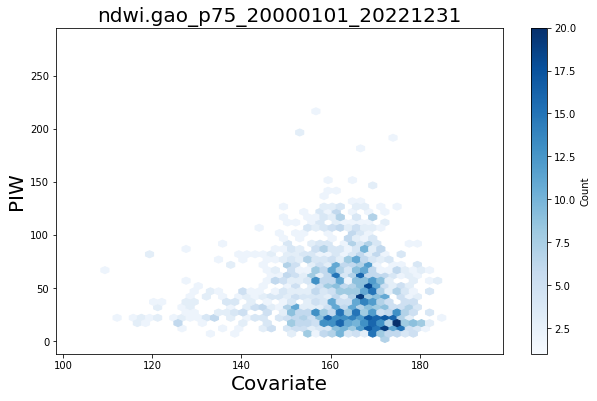

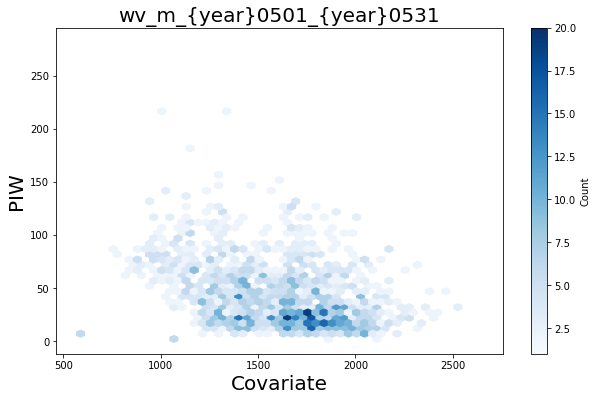

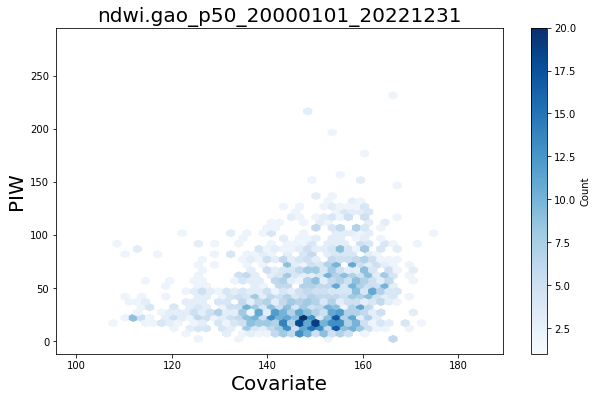

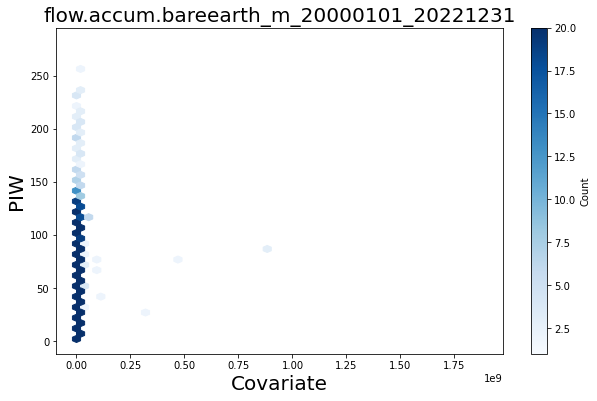

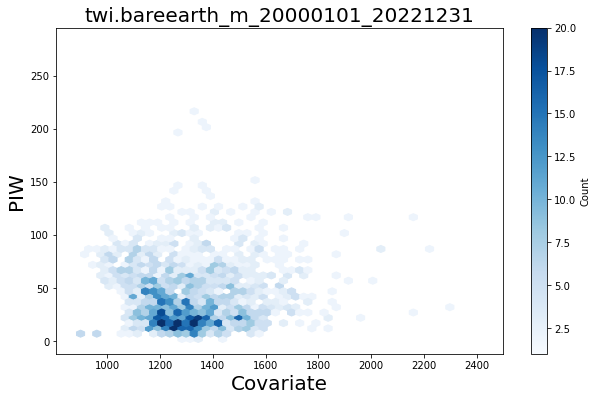

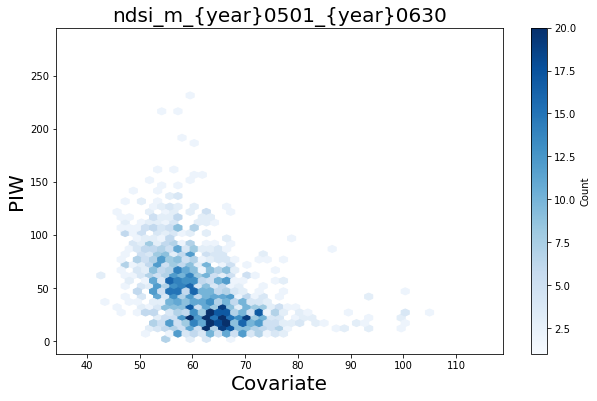

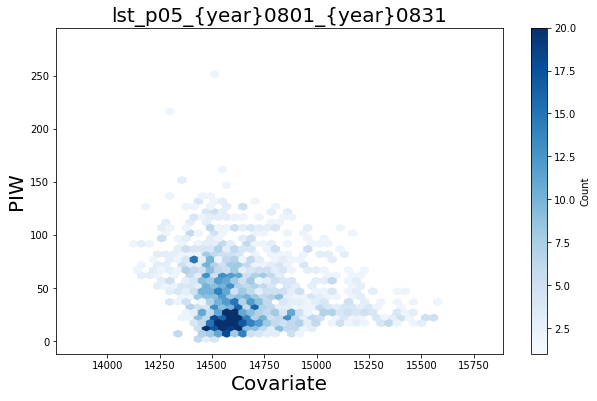

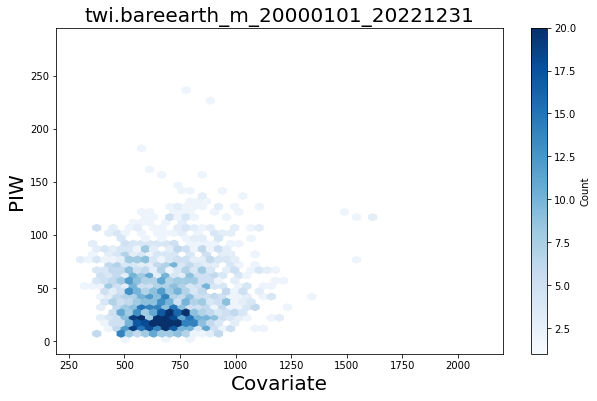

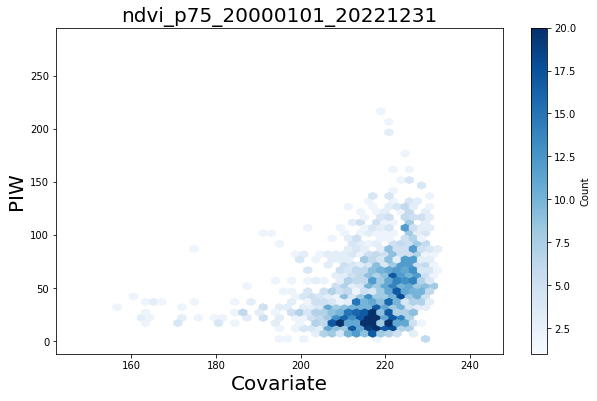

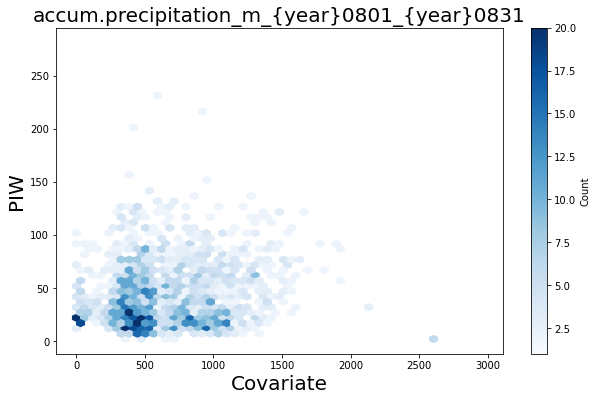

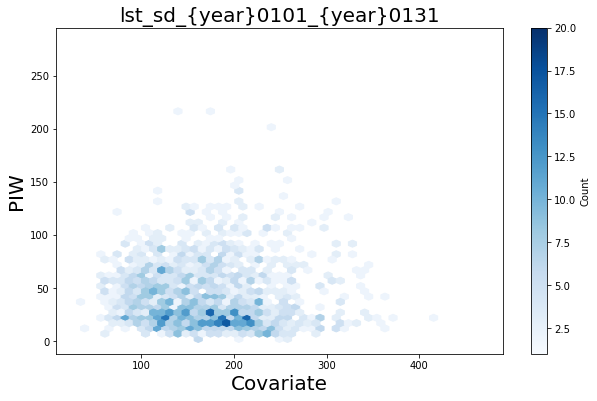

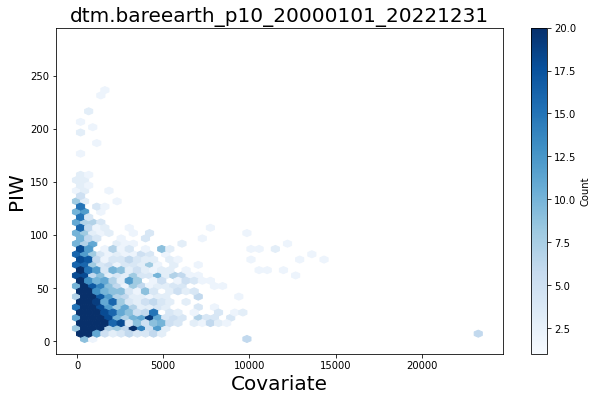

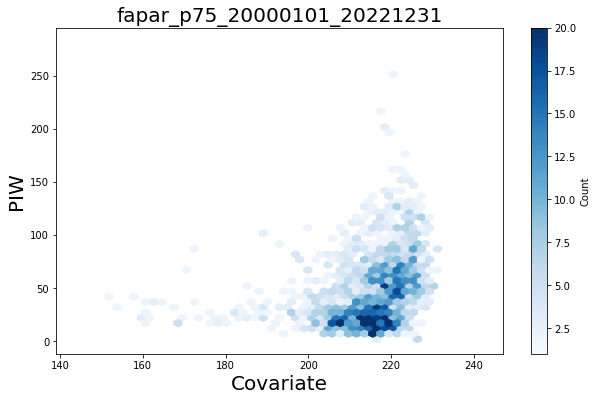

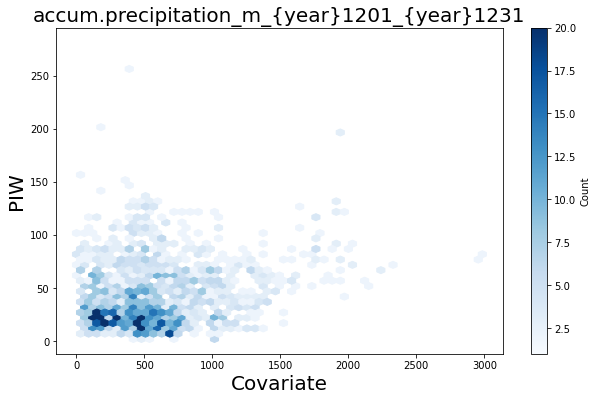

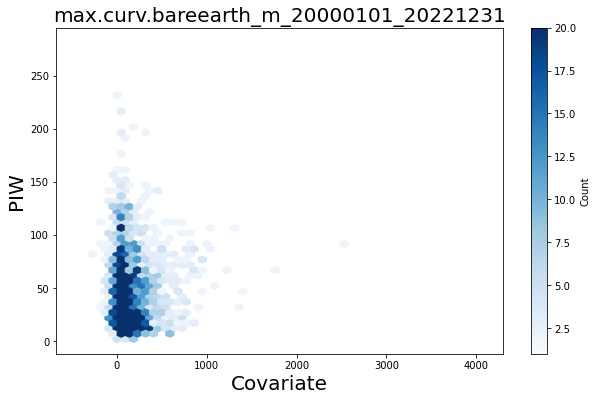

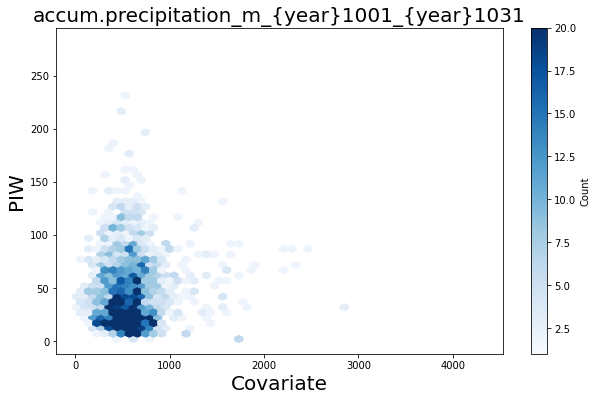

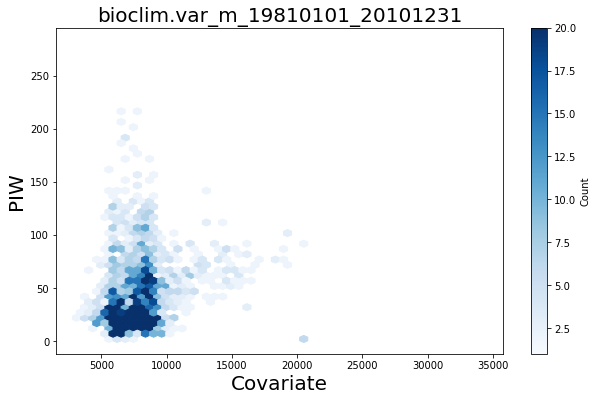

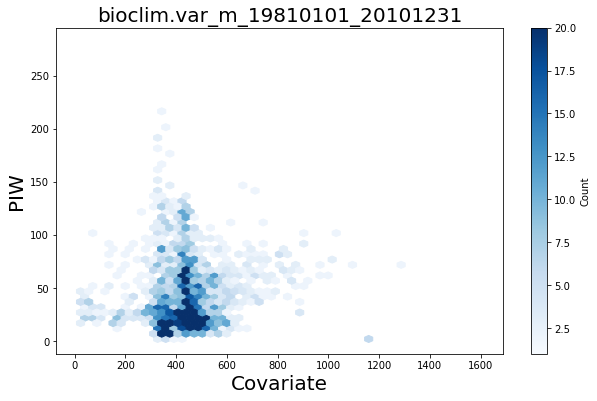

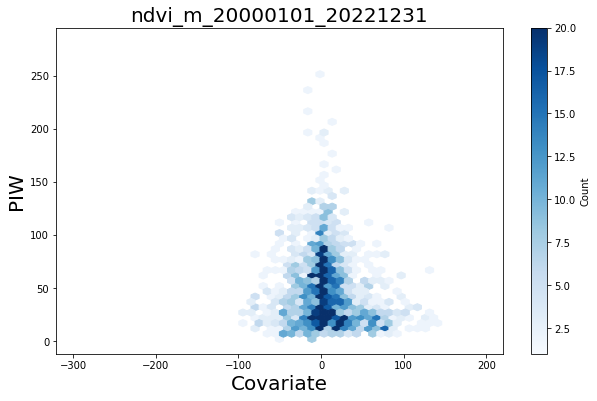

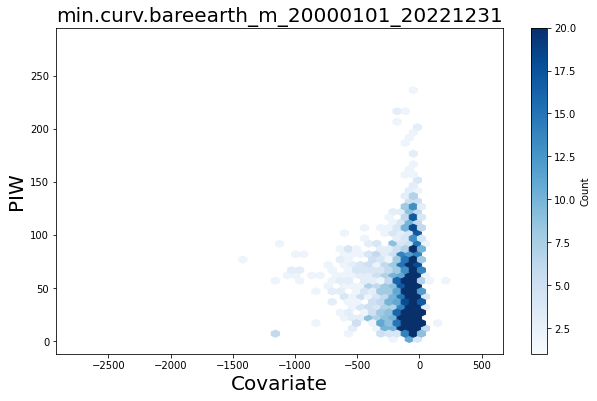

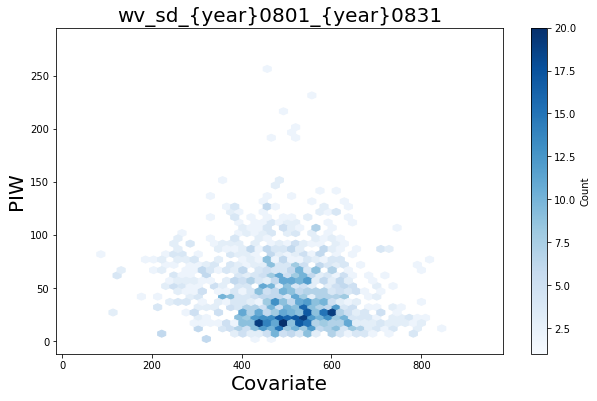

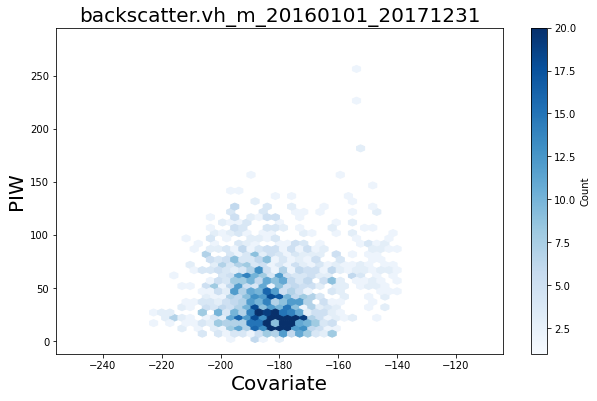

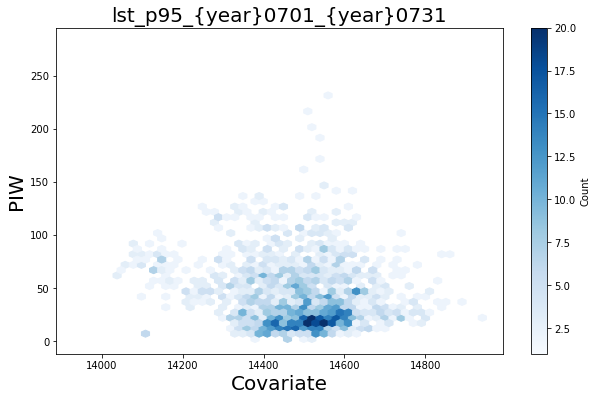

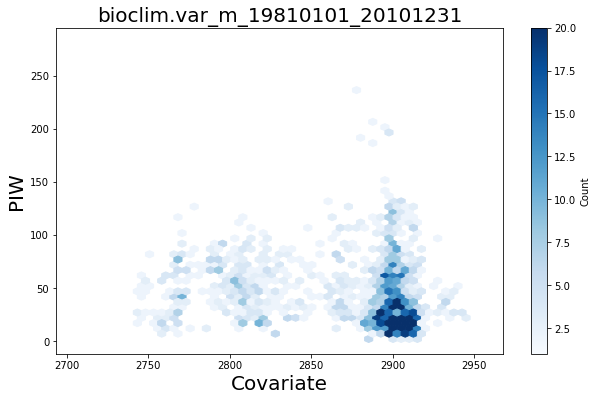

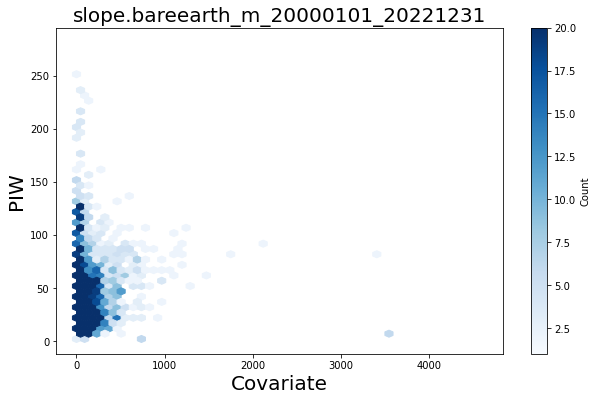

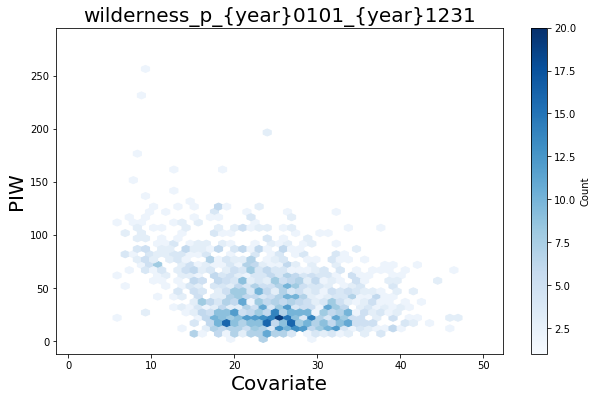

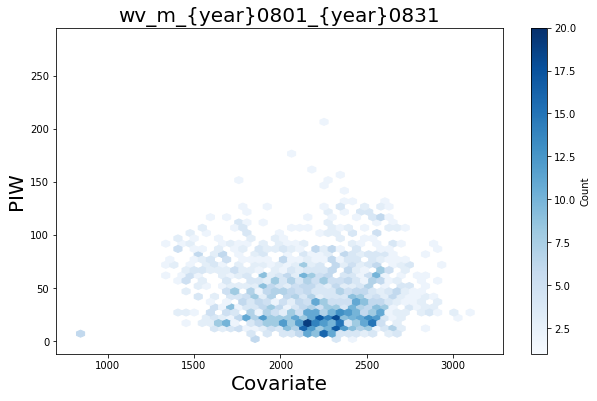

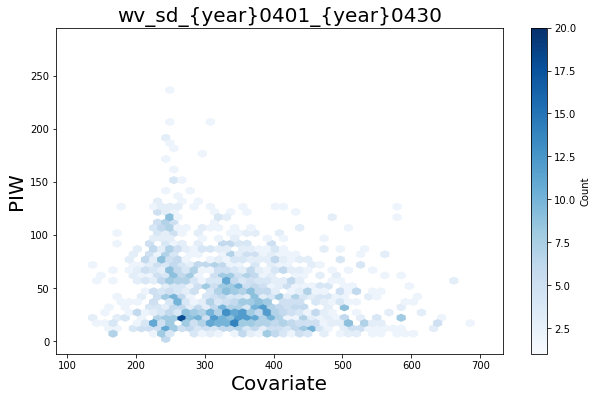

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pi95 = y_q[-1,:]-y_q[1,:]
for xx in covs:
    X = test[xx]
    if len(xx.split('_'))>2:
        nx = xx.split('_')[0]+'_'+xx.split('_')[2]+'_'+xx.split('_')[5]+'_'+xx.split('_')[6]
    else:
        nx = xx
    # Combine into a DataFrame
    data = pd.DataFrame({
        'Covariate': X,
        'Predicted': pi95
    })

    # 1. Create a hexbin plot
    plt.figure(figsize=(10, 6))
    hb = plt.hexbin(data['Covariate'], data['Predicted'], gridsize=50, cmap='Blues', mincnt=2, vmin=1, vmax=20)

    # 2. Add a color bar
    cb = plt.colorbar(hb)
    cb.set_label('Count')

    # # 3. Fit and plot a trend line
    # sns.regplot(x='Covariate', y='Predicted', data=data, scatter=False, color='red', line_kws={"linewidth": 2})

    # 4. Customize the plot
    plt.title(nx,fontsize=20)
    plt.xlabel('Covariate',fontsize=20)
    plt.ylabel('PIW',fontsize=20)
    plt.show()
